In [51]:
import seaborn as sns
from matplotlib import pyplot as plt
from helpers import *
pd.set_option('mode.chained_assignment', None)

In [52]:
# Retrieve the latest DataFrame models
plane_df, cylinder_df, point_df = get_latest_models()

# Extract sleeve data
sleeve_planes, sleeve_cyl, sleeve_points = parts_only_set(plane_df, cylinder_df, point_df, ['INSS', 'GASS', 'SESL'])

## Datum Features

Number of parts:  65
0.938 % acceptance rate


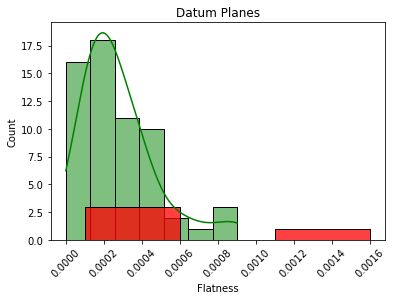

In [75]:
# Spit planes by feature type
datumA, shoulders, midplanes = plane_split(sleeve_planes)

# Split by acceptance decision
apprA = drop_rejections(datumA)
rejA = rejections_only(datumA)

# Print high-level stat
print('Number of parts: ', len(datumA.index))
print(round((len(datumA.index) - len(rejA.index)) / len(datumA.index), 3), '% acceptance rate')

# Plot flatness
sns.histplot(apprA.flatness, kde=True, color='green')
sns.histplot(rejA.flatness, color='red')
plt.xticks(rotation=45)
plt.title('Datum Planes')
plt.xlabel('Flatness')
plt.show()

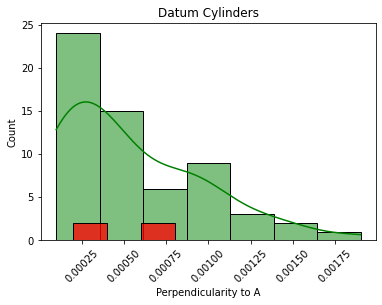

In [103]:
# Calculate egg_rate and deviation features, then split cylinders by feature type
sleeve_cyl['egg_rate'] = sleeve_cyl.cylindricity * 2 / sleeve_cyl.diameter_meas
sleeve_cyl['dia_dev'] = sleeve_cyl.diameter_meas - sleeve_cyl.diameter_nom
datumB, datumC, radials, holes = cylinder_split(sleeve_cyl)

# Calculate wall_thickness and save in datumB
for index, row in sleeve_cyl.iterrows():
    df = sleeve_cyl[sleeve_cyl.inspection_id == row.inspection_id]
    max_dia = df.diameter_meas.max()
    bore_dia = df[df.feature == 'datum cylinder B'].diameter_meas.values[0]
    wall_thickness = max_dia - bore_dia
    datumB.loc[datumB.inspection_id == row.inspection_id, 'wall_thickness'] = wall_thickness

# Spit datumB by acceptance decision
apprB = drop_rejections(datumB)
apprB = apprB[apprB.inspection_id != '133275-INSS-MFG-B_QC1.csv']

rejB = rejections_only(datumB)

# Plot perpendicularity to A
sns.histplot(apprB.perpendicular_a, kde=True, color='green')
sns.histplot(rejB.perpendicular_a, color='red')
plt.xticks(rotation=45)
plt.title('Datum Cylinders')
plt.xlabel('Perpendicularity to A')
plt.show()

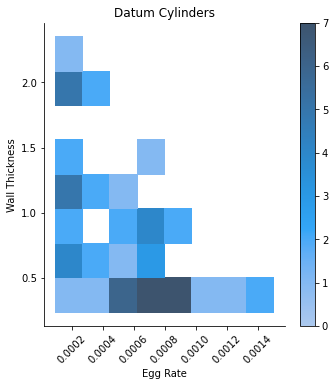

In [104]:
# Plot egg_rate VS wall_thickness
sns.displot(x='egg_rate', y='wall_thickness', data=datumB, cbar=True)
plt.xticks(rotation=45)
plt.title('Datum Cylinders')
plt.xlabel('Egg Rate')
plt.ylabel('Wall Thickness')
plt.show()

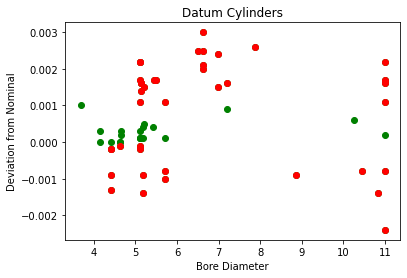

In [105]:
# Split approved parts by pass/fail
inTol = apprB[(apprB.dia_dev >= .0000) | (apprB.dia_dev <= .0010)]
outTol = apprB[(apprB.dia_dev < .0000) | (apprB.dia_dev > .0010)]

# Plot bore diameter deviations
plt.scatter(x=inTol.diameter_meas.tolist(), y=inTol.dia_dev.tolist(), color='green')
plt.scatter(x=outTol.diameter_meas.tolist(), y=outTol.dia_dev.tolist(), color='red')
plt.title('Datum Cylinders')
plt.xlabel('Bore Diameter')
plt.ylabel('Deviation from Nominal')
plt.show()

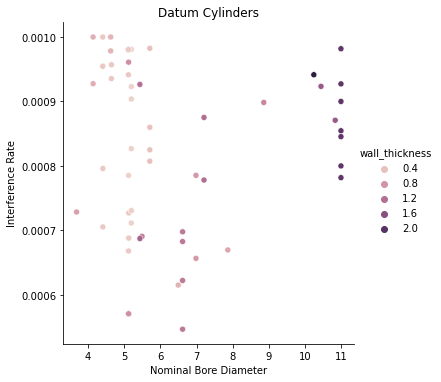

In [109]:
# Plot the rate of interference relative to nominal bore diameter
Bpos = apprB[apprB.dia_dev >= .0000]
Bneg = apprB[apprB.dia_dev < .0000]

Bpos['intf_rate'] = (Bpos.diameter_nom * .0010 - Bpos.dia_dev) / Bpos.diameter_nom
Bneg['intf_rate'] = (Bneg.diameter_nom * .0010 + 1 * Bneg.dia_dev) / Bneg.diameter_nom


Btotal = Bpos.append(Bneg)
sns.relplot(x='diameter_nom', y='intf_rate', data=Btotal, hue='wall_thickness')
plt.title('Datum Cylinders')
plt.xlabel('Nominal Bore Diameter')
plt.ylabel('Interference Rate')
plt.show()